In [1]:
%load_ext rpy2.ipython

In [3]:
%%R

require(dplyr)
require(ggplot2)

In [4]:
import numpy as np
import time

import sys
sys.path.append('../lib')
from Dab import Dab
from Gmt import read_gmt

import igraph
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = "FFFFFF"
plt.rcParams['grid.color'] = "DDDDDD"

In [5]:
d = Dab("../data/brain.dab")
go_terms = read_gmt('../gene_ontology/gobp_human.closed.gmt')

In [43]:
import clustering
reload(clustering)
from clustering import *

In [7]:
# Run clustering tests on a given set of clustering algorithms
def test_clustering_performance(test_generator, transform, cluster, trials_per_test=10):
    #Set up columns to initialize data frame    
    columns = []

    # Check whether each parameter provides an independent variable
    for param in [test_generator, transform, cluster]:
        if isinstance(param, IndependentVar):
            columns.append(param.name)
    
    frame = pd.DataFrame(columns = columns)
    
    results = []
    
    for gen, gen_label in IndependentVar.iterate(test_generator):
        for x in range(trials_per_test):
            dab, metric_kwargs = gen.generateTest()
            for trans, trans_label in IndependentVar.iterate(transform):
                transformed_dab = trans.transform(dab)
                for clust, clust_label in IndependentVar.iterate(cluster):
                        start = time.time()
                        clustering = clust.cluster(transformed_dab)
                        end = time.time()
                        result = {'seconds': end - start}
                        result.update(gen_label)
                        result.update(trans_label)
                        result.update(clust_label)
                        results.append(result)
                
    frame = frame.append(results, ignore_index=True)
    return frame

## Timing tests on random genes

Testing the run time of clustering algorithms on random subsets of the network at various sizes

In [9]:
timing_results = pd.DataFrame()

In [20]:
#Timing tests for size = 10
size = 10
cluster_algs = IndependentVar(
    name = 'Clustering Algorithm',
    values = [GraphCluster(), Louvain(), FastGreedy(), Infomap(), LeadingEigenvector(),
              LabelPropagation(), EdgeBetweenness(), Spinglass(), Walktrap()]
)
test_generator = IndependentVar(
    name = 'Network Size',
    values = [RandomSet(d, size)],
    value_labels = [size]
)
results10 = test_clustering_performance(test_generator, GraphTransform(), cluster_algs)

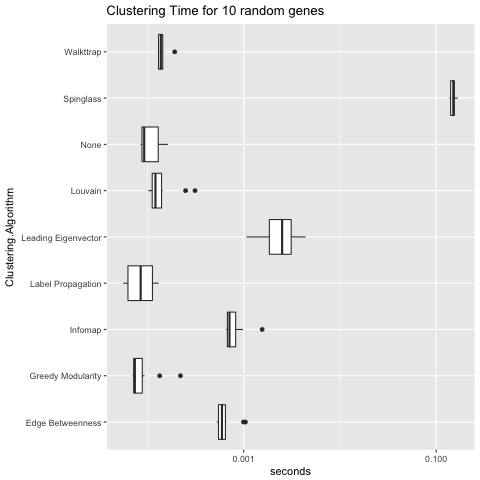

In [27]:
%%R -i results10
g <- ggplot(results10, aes(Clustering.Algorithm, seconds)) + geom_boxplot() + coord_flip() + 
    labs(title="Clustering Time for 10 random genes") + scale_y_log10()
g

In [29]:
#Timing tests for size = 50
size = 50
cluster_algs = IndependentVar(
    name = 'Clustering Algorithm',
    values = [GraphCluster(), Louvain(), FastGreedy(), Infomap(), LeadingEigenvector(),
              LabelPropagation(), EdgeBetweenness(), Spinglass(), Walktrap()]
)
test_generator = IndependentVar(
    name = 'Network Size',
    values = [RandomSet(d, size)],
    value_labels = [size]
)
results50 = test_clustering_performance(test_generator, GraphTransform(), cluster_algs)

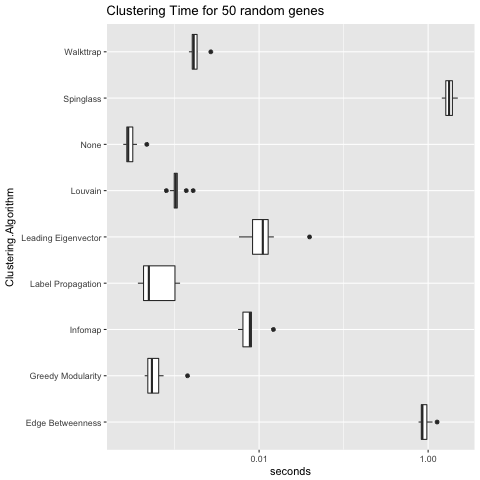

In [31]:
%%R -i results50 
g <- ggplot(results50, aes(Clustering.Algorithm, seconds)) + geom_boxplot() + coord_flip() + 
    labs(title="Clustering Time for 50 random genes") + scale_y_log10()
g

In [32]:
#Timing tests for size = 100
size = 100
cluster_algs = IndependentVar(
    name = 'Clustering Algorithm',
    values = [GraphCluster(), Louvain(), FastGreedy(), Infomap(), LeadingEigenvector(),
              LabelPropagation(), EdgeBetweenness(), Spinglass(), Walktrap()]
)
test_generator = IndependentVar(
    name = 'Network Size',
    values = [RandomSet(d, size)],
    value_labels = [size]
)
results100 = test_clustering_performance(test_generator, GraphTransform(), cluster_algs)

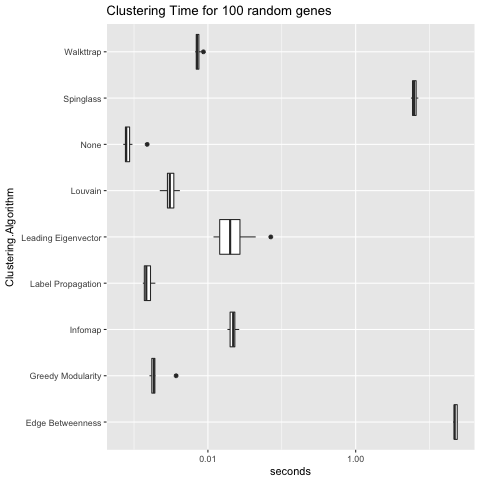

In [34]:
%%R -i results100 
g <- ggplot(results100, aes(Clustering.Algorithm, seconds)) + geom_boxplot() + coord_flip() + 
    labs(title="Clustering Time for 100 random genes") + scale_y_log10()
g

In [35]:
results100.groupby(['Clustering Algorithm'], as_index=False).agg(np.median)

Clustering Algorithm  Network Size    seconds
0     Edge Betweenness         100.0  21.876622
1    Greedy Modularity         100.0   0.001851
2              Infomap         100.0   0.021972
3    Label Propagation         100.0   0.001468
4  Leading Eigenvector         100.0   0.019993
5              Louvain         100.0   0.003053
6                 None         100.0   0.000785
7            Spinglass         100.0   6.173478
8            Walkttrap         100.0   0.007146

### Combined Timing and Performance tests on Random Genes
Run timing and performance tests for various clustering algorithms on randomly selected sets of genes.

Numbers of genes: 10, 50, 100, 500, 1000, 2000, 5000, 10000, 20000  
Stats to measure: execution time, modularity, number of clusters, and the size of clusters  
Algorithms tested:  
- Greedy modularity optimization
- Infomap
- Leading eigenvector (modularity optimization)
- Label propagation
- Louvain
- Edge betweenness
- Spinglass
- Walktrap

Tests are repeated 10 times for trials lasting under 30s each, and 5 times for trials lasting under 1 minute each. Tests that take longer than 1 minute to run are terminated


In [38]:
# Timeout functionality
import signal, time

# Timeout Class from Stack Overflow answer http://stackoverflow.com/a/8465202
class Timeout():
    """Timeout class using ALARM signal"""
    class Timeout(Exception): 
        pass
    
    def __init__(self, sec):
        self.sec = sec
    
    def __enter__(self):
        signal.signal(signal.SIGALRM, self.raise_timeout)
        signal.alarm(self.sec)

    def __exit__(self, *args):
        signal.alarm(0) # disable alarm

    def raise_timeout(self, *args):
        raise Timeout.Timeout()

#Usage example
print "2s timeout on 1s operation:",
try:
    with Timeout(2):
        time.sleep(1)
    print "No timeout"
except Timeout.Timeout:
    print "Operation timed out"

print "2s timeout on 3s operation:",
try:
    with Timeout(2):
        time.sleep(3)
    print "No timeout"
except Timeout.Timeout:
    print "Operation timed out"
    

2s timeout on 1s operation: No timeout
2s timeout on 3s operation: Operation timed out


In [72]:
#Note: the test_generator objects should be sorted in order of increasing time to run
def test_clustering_performance_and_runtime(test_generator, transform, cluster, metrics,
                                            fast_trial_count=10, slow_trial_count=5, slow_cutoff=30, max_cutoff=60):
    #Set up columns to initialize data frame    
    columns = []

    # Check whether each parameter provides an independent variable
    for param in [test_generator, transform, cluster]:
        if isinstance(param, IndependentVar):
            columns.append(param.name)
    
    # Add columns for each metric
    for m in metrics:
        columns.append(m.name)
        
    columns.append('seconds')
    
    frame = pd.DataFrame(columns = columns)
    
    results = []
    
    # Marks whether an algorithm has timed out yet on any of its inputs
    algorithm_status = {
        clust.name: 'fast' for clust, _ in IndependentVar.iterate(cluster)
    }
    
    
    for gen, gen_label in IndependentVar.iterate(test_generator):
        if all(status == "disabled" for status in algorithm_status.values()):
            break
        print "\n### Number of genes: %d ###" % gen.name
        for trial in range(fast_trial_count):
            print "\nTrial %d:" % (trial+1),
            dab, metric_kwargs = gen.generateTest()
            for trans, trans_label in IndependentVar.iterate(transform):
                transformed_dab = trans.transform(dab)
                for clust, clust_label in IndependentVar.iterate(cluster):
                    #Stop the trials if we are over time
                    if algorithm_status[clust.name] == 'disabled':
                        continue
                    elif algorithm_status[clust.name] == 'slow' and trial >= slow_trial_count:
                        continue
                    try:
                        with Timeout(max_cutoff):
                            start = time.time()
                            clustering = clust.cluster(transformed_dab)
                            end = time.time()
                        
                        result = {m.name: m.score(clustering, **metric_kwargs) for m in metrics}
                        result['seconds'] = end - start
                        #Add in keys for our Independent Variable labels
                        result = reduce(lambda x, y: dict(x.items() + y.items()), [result, gen_label, trans_label, clust_label])
                        results.append(result)
                        print clust.name,
                        #Check if the algorithm is running too slow
                        if algorithm_status[clust.name] == 'fast' and result['seconds'] > slow_cutoff:
                            algorithm_status[clust.name] = 'slow'
                            print "Marked %s as slow" % clust.name
                    except Timeout.Timeout:
                        print "Marked %s as disabled" % clust.name
                        algorithm_status[clust.name] = 'disabled'

    frame = frame.append(results, ignore_index=True)
    return frame

In [73]:
cluster_algs = IndependentVar(
    name = 'Clustering Algorithm',
    values = [GraphCluster(), Louvain(), FastGreedy(), Infomap(), LeadingEigenvector(),
              LabelPropagation(), EdgeBetweenness(), Spinglass(), Walktrap()]
)

test_sizes = [10, 50, 100, 500, 1000, 5000, 10000, 15000, 20000]
test_generators = IndependentVar(
    name = 'Network Size',
    values = [RandomSet(d, n) for n in test_sizes],
    value_labels = test_sizes
)

metrics = [Modularity(), ClusterCount(), ClusterSizes()]
results = test_clustering_performance_and_runtime(test_generators, GraphTransform(), cluster_algs, metrics)


### Number of genes: 10 ###

Trial 1: None Louvain Greedy Modularity Infomap Leading Eigenvector Label Propagation Edge Betweenness Spinglass Walkttrap 
Trial 2: None Louvain Greedy Modularity Infomap Leading Eigenvector Label Propagation Edge Betweenness Spinglass Walkttrap 
Trial 3: None Louvain Greedy Modularity Infomap Leading Eigenvector Label Propagation Edge Betweenness Spinglass Walkttrap 
Trial 4: None Louvain Greedy Modularity Infomap Leading Eigenvector Label Propagation Edge Betweenness Spinglass Walkttrap 
Trial 5: None Louvain Greedy Modularity Infomap Leading Eigenvector Label Propagation Edge Betweenness Spinglass Walkttrap 
Trial 6: None Louvain Greedy Modularity Infomap Leading Eigenvector Label Propagation Edge Betweenness Spinglass Walkttrap 
Trial 7: None Louvain Greedy Modularity Infomap Leading Eigenvector Label Propagation Edge Betweenness Spinglass Walkttrap 
Trial 8: None Louvain Greedy Modularity Infomap Leading Eigenvector Label Propagation Edge Betweenness

In [81]:
results.to_csv("performance_tests_no_transform.tsv",sep="\t", index=False)

In [74]:
results

Network Size Clustering Algorithm    Modularity  Number of Clusters  \
0            10.0                 None  0.000000e+00                 1.0   
1            10.0              Louvain  6.985204e-02                 2.0   
2            10.0    Greedy Modularity  6.985204e-02                 2.0   
3            10.0              Infomap  0.000000e+00                 1.0   
4            10.0  Leading Eigenvector  6.985204e-02                 2.0   
5            10.0    Label Propagation  0.000000e+00                 1.0   
6            10.0     Edge Betweenness  5.830323e-05                 3.0   
7            10.0            Spinglass  6.985204e-02                 2.0   
8            10.0            Walkttrap  6.985204e-02                 2.0   
9            10.0                 None  0.000000e+00                 1.0   
10           10.0              Louvain  0.000000e+00                 1.0   
11           10.0    Greedy Modularity  0.000000e+00                 1.0   
12           10.0              Infomap  0.000000e+00                 1.0   
13           10.0  Leading Eigenvector  0.000000e+00                 1.0   
14           10.0    Label Propagation  0.000000e+00                 1.0   
15           10.0     Edge Betweenness  0.000000e+00                 1.0   
16           10.0            Spinglass  0.000000e+00                 1.0   
17           10.0            Walkttrap  0.000000e+00                 1.0   
18           10.0                 None  0.000000e+00                 1.0   
19           10.0              Louvain  4.613744e-02                 2.0   
20           10.0    Greedy Modularity  4.613744e-02                 2.0   
21           10.0              Infomap  0.000000e+00                 1.0   
22           10.0  Leading Eigenvector  3.767430e-02                 2.0   
23           10.0    Label Propagation  0.000000e+00                 1.0   
24           10.0     Edge Betweenness  0.000000e+00                 1.0   
25           10.0            Spinglass  1.636395e-02                 4.0   
26           10.0            Walkttrap  4.613744e-02                 2.0   
27           10.0                 None  0.000000e+00                 1.0   
28           10.0              Louvain  2.212246e-03                 2.0   
29           10.0    Greedy Modularity  2.212246e-03                 2.0   
..            ...                  ...           ...                 ...   
411        5000.0              Louvain  5.262000e-02                 3.0   
412        5000.0    Label Propagation  5.773160e-15                 1.0   
413        5000.0                 None  0.000000e+00                 1.0   
414        5000.0              Louvain  5.339339e-02                 3.0   
415        5000.0    Label Propagation  1.132427e-14                 1.0   
416        5000.0                 None  0.000000e+00                 1.0   
417        5000.0              Louvain  5.208533e-02                 3.0   
418        5000.0    Label Propagation  5.107026e-15                 1.0   
419        5000.0                 None  0.000000e+00                 1.0   
420        5000.0              Louvain  5.172052e-02                 3.0   
421        5000.0    Label Propagation  3.330669e-15                 1.0   
422        5000.0                 None  0.000000e+00                 1.0   
423        5000.0              Louvain  5.173854e-02                 3.0   
424        5000.0    Label Propagation  4.662937e-15                 1.0   
425        5000.0                 None  0.000000e+00                 1.0   
426        5000.0              Louvain  5.210927e-02                 3.0   
427        5000.0    Label Propagation -3.108624e-15                 1.0   
428        5000.0                 None  0.000000e+00                 1.0   
429        5000.0              Louvain  5.345801e-02                 3.0   
430        5000.0    Label Propagation -3.996803e-15                 1.0   
431        5000.0                 None  0.000000e+00 

In [ ]:
cluster_algs = IndependentVar(
    name = 'Clustering Algorithm',
    values = [GraphCluster(), Louvain(), FastGreedy(), Infomap(), LeadingEigenvector(),
              LabelPropagation(), EdgeBetweenness(), Spinglass(), Walktrap()]
)

#Run tests on random graphs
test_sizes = [10, 50, 100, 500, 1000, 5000, 10000, 15000, 20000]
test_repetitions [10, 10, 10, 10, 5, 5]
timing_results = pd.DataFrame()
for t in test_sizes:
    print "Testing size", t
    test_generator = IndependentVar(
        name = 'Network Size',
        values = [RandomSet(d, t)],
        value_labels = [t]
    )
    results = test_clustering_performance(test_generator, GraphTransform(), cluster_algs)
    timing_results = timing_results.append(results)

#timing_results2 = test_clustering_performance(test_generators, GraphTransform(), cluster_algs)


In [62]:
cluster_algs = IndependentVar(
    name = 'Clustering Algorithm',
    values = [GraphCluster(), Louvain()]
)

test_sizes = [10, 50, 100, 200, 500, 1000, 5000]
test_generators = IndependentVar(
    name = 'Network Size',
    values = [RandomSet(d, n) for n in test_sizes],
    value_labels = test_sizes
)

timing_results = test_clustering_performance(test_generators, GraphTransform(), cluster_algs)

In [65]:

from time import sleep

for i in tnrange(10, desc='1st loop', leave=False):
    sleep(0.1)

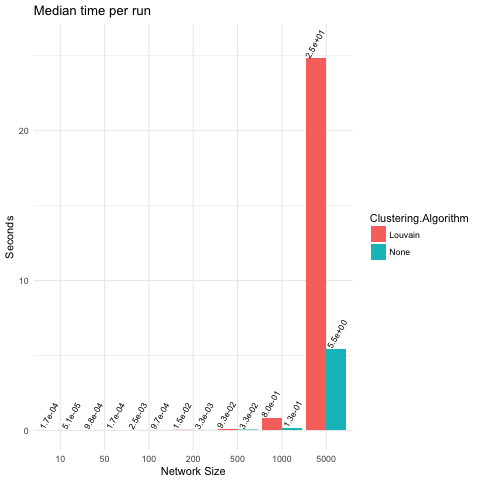

In [162]:
%%R -i medians

g <- ggplot(medians, aes(as.factor(Network.Size), weight=seconds, fill=Clustering.Algorithm)) + 
        geom_bar(position="dodge") + theme_minimal() + 
        geom_text(aes(label=format(seconds,digits=2), y = seconds + 1), 
                  angle=60, position=position_dodge(width=1), size=3) +
        labs(title="Median time per run", x = "Network Size", y="Seconds")
g

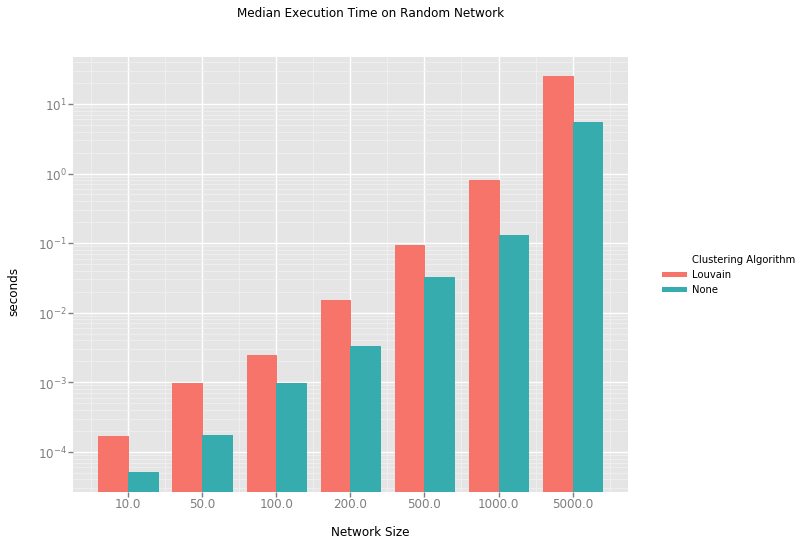

<ggplot: (301549721)>


In [103]:
from ggplot import *

medians = timing_results.groupby(['Clustering Algorithm', 'Network Size'], as_index=False).agg(np.median)

print ggplot(medians, aes('Network Size', 'seconds',weight='seconds', fill='Clustering Algorithm')) + \
        geom_bar(stat="identity") + \
        ggtitle('Median Execution Time on Random Network') + scale_y_log()
        
        #geom_text(aes(label='seconds')) + \

In [104]:
medians = timing_results.groupby(['Clustering Algorithm', 'Network Size'], as_index=False).agg(np.median)


#fig, ax = plt.subplots()
#for label, df in medians.groupby('Clustering Algorithm'):
#    ax.plot(df['Network Size'], df['seconds'], label=label)
#plt.legend()
#plt.show()
medians
#medians.groupby('Clustering Algorithm').plot(x='Cluster Size', y='seconds', sharex=True, sharey=True)
#plt.show()
#medians

#plot(x='Cluster Size', y=timing_results['Seconds'].m)
#timing_results.groupby(['Clustering Algorithm']).plot(x = 'Cluster Size', y = 'seconds')


Clustering Algorithm  Network Size    seconds
0               Louvain          10.0   0.000169
1               Louvain          50.0   0.000976
2               Louvain         100.0   0.002460
3               Louvain         200.0   0.015196
4               Louvain         500.0   0.092941
5               Louvain        1000.0   0.803743
6               Louvain        5000.0  24.835891
7                  None          10.0   0.000051
8                  None          50.0   0.000172
9                  None         100.0   0.000974
10                 None         200.0   0.003275
11                 None         500.0   0.032921
12                 None        1000.0   0.131325
13                 None        5000.0   5.450013